In [1]:
import requests
import json
from pprint import pprint
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics.pairwise import cosine_similarity

#import spotify keys
from config import client_id
from config import client_secret

# Creating Access Token for Spotify API

In [2]:
def createToken():
    #generate access token for spotify api
    #from: https://stmorse.github.io/journal/spotify-api.html

    AUTH_URL = 'https://accounts.spotify.com/api/token'

    # POST
    auth_response = requests.post(AUTH_URL, {
        'grant_type': 'client_credentials',
        'client_id': client_id,
        'client_secret': client_secret,
    })

    # convert the response to JSON
    auth_response_data = auth_response.json()

    # save the access token
    access_token = auth_response_data['access_token']

    #In order to access, we send a properly formed GET request to the API server, with our access_token in the header. Let’s save this header info now, in the following very specific format:
    headers = {
        'Authorization': 'Bearer {token}'.format(token=access_token)
    }
    
    return headers

# Requesting Input from User

(these three cells just for testing - app input will be taken from streamlit page)

In [3]:
search_track = input("Please name a song: ").replace('"', '').replace("'", '').replace("!",'')

Please name a song:  born to run


In [4]:
search_artist = input("Please name that song's artist: ").replace('"', '').replace("'", '')

Please name that song's artist:  bruce springsteen


In [5]:
# options for dropdown: ['Global', 'Vietnam', 'Venezuela', 'Uruguay', 'United Kingdom', 'Ukraine', 'UAE', 'Turkey', 'Thailand', 'Taiwan', 'Switzerland', 'Sweden', 'Spain', 'South Korea', 'South Africa', 'Slovakia', 'Singapore', 'Saudi Arabia', 'Romania', 'Portugal', 'Poland', 'Philippines', 'Peru', 'Paraguay', 'Panama', 'Pakistan', 'Norway', 'Nigeria', 'Nicaragua', 'New Zealand', 'Netherlands', 'Mexico', 'Malaysia', 'Luxembourg', 'Lithuania', 'Latvia', 'Kazakhstan', 'Japan', 'Italy', 'Israel', 'Ireland', 'Indonesia', 'Hungary', 'Hong Kong', 'Honduras', 'Guatemala', 'Greece', 'Germany', 'France', 'Finland', 'Estonia', 'El Salvador', 'Egypt', 'Ecuador', 'Dominican Republic', 'Denmark', 'Czech Republic', 'Cyprus', 'Costa Rica', 'Colombia', 'Chile', 'Canada', 'Bulgaria', 'Brazil', 'Bolivia', 'Belgium', 'Belarus', 'Austria', 'Australia', 'Argentina']
region = input("Please select a region: ")

Please select a region:  Global


# Function to Search for Matching Track Using Spotify API, Create DF of Track Features

will be called/used within main function for recommending 5 new songs

In [6]:
def searchTrack(track,artist):
    #base URL for Spotify API search
    search_url = 'https://api.spotify.com/v1/search'
    
    # API search for track & artist input by user
    response = requests.get(search_url + '?q=track%3A' + track + '%20artist%3A' + artist + '&type=track%2Cartist&limit=1', headers=createToken()).json()
    
    # storing track id, artist, and track name from API search as variables
    track_id = response['tracks']['items'][0]["id"]
    artist_names = response['tracks']['items'][0]["artists"][0]['name']
    track_name = response['tracks']['items'][0]["name"]
    
    #base URL for Spotify API
    base_url = 'https://api.spotify.com/v1/'
    # API call to collect track features
    track_response = requests.get(base_url + 'audio-features/' + track_id, headers=createToken()).json()
    
    #empty lists to store song data retrieved from API call
    danceability = []
    energy = []
    # key = []
    loudness = []
    mode = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence = []
    tempo = []
    id_num = []
    # duration_mins = []
    # time_signature = []

    #fill in track info for each audio feature / empty list
    danceability.append(track_response["danceability"])
    energy.append(track_response["energy"])
    # key.append(track_response["key"])
    loudness.append(track_response["loudness"])
    mode.append(track_response["mode"])
    speechiness.append(track_response["speechiness"])
    acousticness.append(track_response["acousticness"])
    instrumentalness.append(track_response["instrumentalness"])
    liveness.append(track_response["liveness"])
    valence.append(track_response["valence"])
    tempo.append(track_response["tempo"])
    id_num.append(track_response["id"])
    # # duration recorded in api in milliseconds, converting to minutes here
    # duration_mins.append(round((track_response["duration_ms"] / 60000),2))
    # time_signature.append(track_response["time_signature"])    

    #create a dictionary to hold data gathered from the api
    track_dict = {
        "track_id": id_num,
        "track_name": track_name,
        "artist_names": artist_names,
        "danceability": danceability,
        "energy": energy,
        # "key": key,
        "loudness": loudness,
        "mode": mode,
        "speechiness": speechiness,
        "acousticness": acousticness,
        "instrumentalness": instrumentalness,
        "liveness": liveness,
        "valence": valence,
        "tempo": tempo,
        # "duration_mins": duration_mins,
        # "time_signature": time_signature,

    }
    #convert dictionary to a dataframe
    input_track_df = pd.DataFrame(track_dict)
    # input_track_df = input_track_df.drop(columns=['duration_mins'])
    
    return input_track_df

In [7]:
# test function
input_track_df = searchTrack(search_track,search_artist)
input_track_df

,track_id,track_name,artist_names,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,6hTcuIQa0sxrrByu9wTD7s,Born to Run,Bruce Springsteen,0.27,0.944,-4.199,1,0.0975,0.00501,0.000021,0.116,0.606,146.347


# Function to Recommend 5 Tracks from Selected Top 200 Chart

In [8]:
# function to recommend 5 most similar tracks from selected chart
def recommendSongs(track, artist, region):
    # run function to create DF with input track and its audio features
    user_track_df = searchTrack(track,artist)
    
    #import CSVs created in "pulling_chart_track_features.ipynb" and save as individual dfs
    features_csv_list = {"Global":"global_df.csv", "Vietnam":"vietnam_df.csv","Venezuela":"venezuela_df.csv",
    "Uruguay":"uruguay_df.csv","United Kingdom":"united_kingdom_df.csv","Ukraine":"ukraine_df.csv",
    "UAE":"uae_df.csv","Turkey":"turkey_df.csv","Thailand":"thailand_df.csv",
    "Taiwan":"taiwan_df.csv","Switzerland":"switzerland_df.csv","Sweden":"sweden_df.csv",
    "Spain":"spain_df.csv","South Korea":"south_korea_df.csv","South Africa":"south_africa_df.csv",
    "Slovakia":"slovakia_df.csv","Singapore":"singapore_df.csv","Saudi Arabia":"saudi_arabia_df.csv",
    "Romania":"romania_df.csv","Portugal":"portugal_df.csv","Poland":"poland_df.csv",
    "Philippines":"philippines_df.csv","Peru":"peru_df.csv","Paraguay":"paraguay_df.csv",
    "Panama":"panama_df.csv","Pakistan":"pakistan_df.csv","Norway":"norway_df.csv",
    "Nigeria":"nigeria_df.csv","Nicaragua":"nicaragua_df.csv","New Zealand":"new_zealand_df.csv",
    "Netherlands":"netherlands_df.csv","Mexico":"mexico_df.csv",
    "Malaysia":"malaysia_df.csv","Luxembourg":"luxembourg_df.csv","Lithuania":"lithuania_df.csv",
    "Latvia":"latvia_df.csv","Kazakhstan":"kazakhstan_df.csv","Japan":"japan_df.csv",
    "Italy":"italy_df.csv","Israel":"israel_df.csv","Ireland":"ireland_df.csv",
    "Indonesia":"indonesia_df.csv",
    "Hungary":"hungary_df.csv","Hong Kong":"hong_kong_df.csv","Honduras":"honduras_df.csv",
    "Guatemala":"guatemala_df.csv","Greece":"greece_df.csv","Germany":"germany_df.csv",
    "France":"france_df.csv","Finland":"finland_df.csv","Estonia":"estonia_df.csv",
    "El Salvador":"el_salvador_df.csv","Egypt":"egypt_df.csv","Ecuador":"ecuador_df.csv",
    "Dominican Republic":"dominican_republic_df.csv","Denmark":"denmark_df.csv","Czech Republic":"czech_republic_df.csv","Cyprus":"cyprus_df.csv","Costa Rica":"costa_rica_df.csv","Colombia":"colombia_df.csv","Chile":"chile_df.csv","Canada":"canada_df.csv","Bulgaria":"bulgaria_df.csv","Brazil":"brazil_df.csv","Bolivia":"bolivia_df.csv","Belgium":"belgium_df.csv","Belarus":"belarus_df.csv","Austria":"austria_df.csv","Australia":"australia_df.csv","Argentina":"argentina_df.csv"}
    # currently not working w/ api calls: "morocco":"morocco_df.csv","india":"india_df.csv","iceland":"iceland_df.csv"

    d = {}

    for key in features_csv_list:
        d[key] = pd.read_csv(f'resources/top_chart_features/{features_csv_list[key]}') 
        d[key] = d[key].drop(columns=['region','key','duration_mins','time_signature'])

    selected_chart_df = d[region]
    
    # create combined df of the track features from the input track and all of the tracks from the selected regional chart
    # row 0 will be the input song
    combined_df = pd.concat([user_track_df,selected_chart_df.loc[:]]).reset_index(drop=True)    
    
    # scale data (only features columns), create df of scaled data
    scaler = StandardScaler()
    # if using song_duration, needs to be combined_df.iloc[:, 3:16]
    # if using key and time_signature, needs to be combined_df.iloc[:, 3:15]
    chart_scaled = scaler.fit_transform(combined_df.iloc[:, 3:13])
    chart_scaled_df = pd.DataFrame(chart_scaled, columns=combined_df.iloc[:, 3:13].columns)

    # create array for input track data
    array1 = chart_scaled_df.iloc[0,:].to_numpy().reshape(1, -1)
    # create array for selected chart
    array2 = chart_scaled_df.iloc[1:,:].to_numpy()

    # run cosine similarity
    cosine_sim = cosine_similarity(array1, array2)
    
    # create list that is ranked by score, descending order
    sim_scores = list(enumerate(cosine_sim[-1,:]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # create empty list to store recommendations
    ranked_tracks = []

    for i in range(0, 5):
        indx = sim_scores[i][0]
        ranked_tracks.append([combined_df['track_id'].iloc[indx], combined_df['track_name'].iloc[indx], combined_df['artist_names'].iloc[indx], sim_scores[i][1], combined_df['danceability'].iloc[indx], combined_df['energy'].iloc[indx], combined_df['loudness'].iloc[indx], combined_df['mode'].iloc[indx], combined_df['speechiness'].iloc[indx], combined_df['acousticness'].iloc[indx], combined_df['instrumentalness'].iloc[indx], combined_df['liveness'].iloc[indx], combined_df['valence'].iloc[indx], combined_df['tempo'].iloc[indx]])
        df = pd.DataFrame(ranked_tracks)
        df.columns = ['Track ID', 'Track Name', 'Artist Name(s)', 'Similarity Score', 'Danceability','Energy','Loudness','Mode','Speechiness','Acousticness','Instrumentalness','Liveness','Valence','Tempo']
        df.index = np.arange(1, len(df) + 1)
    return df

In [9]:
# testing function
recommendSongs(search_track,search_artist,region)

,Track ID,Track Name,Artist Name(s),Similarity Score,Danceability,Energy,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
1,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,The Weeknd,0.921811,0.514,0.730,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005
2,4woTEX1wYOTGDqNXuavlRC,Superman,"Eminem, Dina Rae",0.868864,0.802,0.755,-3.138,0,0.0564,0.02150,0.000000,0.2950,0.580,130.027
3,1JSTJqkT5qHq8MDJnJbRE1,Every Breath You Take,The Police,0.860820,0.820,0.452,-9.796,1,0.0348,0.54300,0.002940,0.0714,0.740,117.401
4,3uUuGVFu1V7jTQL60S1r8z,Where Are You Now,"Lost Frequencies, Calum Scott",0.722003,0.671,0.636,-8.117,0,0.1030,0.51500,0.000411,0.1720,0.262,120.966
5,0fea68AdmYNygeTGI4RC18,LA CANCIÓN,"J Balvin, Bad Bunny",0.721380,0.754,0.646,-5.795,1,0.3170,0.15200,0.000018,0.1080,0.429,176.089


# (Keep cell below for testing track search)

In [10]:
#base URL for Spotify API search
search_url = 'https://api.spotify.com/v1/search'

response = requests.get(search_url + '?q=track%3A' + search_track + '%20artist%3A' + search_artist + '&type=track%2Cartist&limit=1', headers=createToken()).json()

pprint(response)

# track_id = response['tracks']['items'][0]["id"]
# artist_names = response['tracks']['items'][0]["artists"][0]['name']
# track_name = response['tracks']['items'][0]["name"]

{'artists': {'href': 'https://api.spotify.com/v1/search?query=track%3Aborn+to+run+artist%3Abruce+springsteen&type=artist&offset=0&limit=1',
             'items': [],
             'limit': 1,
             'next': None,
             'offset': 0,
             'previous': None,
             'total': 0},
 'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3Aborn+to+run+artist%3Abruce+springsteen&type=track&offset=0&limit=1',
            'items': [{'album': {'album_type': 'album',
                                 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3eqjTLE0HfPfh78zjh6TqT'},
                                              'href': 'https://api.spotify.com/v1/artists/3eqjTLE0HfPfh78zjh6TqT',
                                              'id': '3eqjTLE0HfPfh78zjh6TqT',
                                              'name': 'Bruce Springsteen',
                                              'type': 'artist',
                                       

# Reading in CSVs of Regional and Global Top 200 Charts

(for testing, also getting a list of all chart options)

In [11]:
#import CSVs created in "pulling_chart_track_features.ipynb" and save as individual dfs
features_csv_list = {"Global":"global_df.csv", "Vietnam":"vietnam_df.csv","Venezuela":"venezuela_df.csv",
"Uruguay":"uruguay_df.csv","United Kingdom":"united_kingdom_df.csv","Ukraine":"ukraine_df.csv",
"UAE":"uae_df.csv","Turkey":"turkey_df.csv","Thailand":"thailand_df.csv",
"Taiwan":"taiwan_df.csv","Switzerland":"switzerland_df.csv","Sweden":"sweden_df.csv",
"Spain":"spain_df.csv","South Korea":"south_korea_df.csv","South Africa":"south_africa_df.csv",
"Slovakia":"slovakia_df.csv","Singapore":"singapore_df.csv","Saudi Arabia":"saudi_arabia_df.csv",
"Romania":"romania_df.csv","Portugal":"portugal_df.csv","Poland":"poland_df.csv",
"Philippines":"philippines_df.csv","Peru":"peru_df.csv","Paraguay":"paraguay_df.csv",
"Panama":"panama_df.csv","Pakistan":"pakistan_df.csv","Norway":"norway_df.csv",
"Nigeria":"nigeria_df.csv","Nicaragua":"nicaragua_df.csv","New Zealand":"new_zealand_df.csv",
"Netherlands":"netherlands_df.csv","Mexico":"mexico_df.csv",
"Malaysia":"malaysia_df.csv","Luxembourg":"luxembourg_df.csv","Lithuania":"lithuania_df.csv",
"Latvia":"latvia_df.csv","Kazakhstan":"kazakhstan_df.csv","Japan":"japan_df.csv",
"Italy":"italy_df.csv","Israel":"israel_df.csv","Ireland":"ireland_df.csv",
"Indonesia":"indonesia_df.csv",
"Hungary":"hungary_df.csv","Hong Kong":"hong_kong_df.csv","Honduras":"honduras_df.csv",
"Guatemala":"guatemala_df.csv","Greece":"greece_df.csv","Germany":"germany_df.csv",
"France":"france_df.csv","Finland":"finland_df.csv","Estonia":"estonia_df.csv",
"El Salvador":"el_salvador_df.csv","Egypt":"egypt_df.csv","Ecuador":"ecuador_df.csv",
"Dominican Republic":"dominican_republic_df.csv","Denmark":"denmark_df.csv","Czech Republic":"czech_republic_df.csv",
"Cyprus":"cyprus_df.csv","Costa Rica":"costa_rica_df.csv","Colombia":"colombia_df.csv",
"Chile":"chile_df.csv","Canada":"canada_df.csv","Bulgaria":"bulgaria_df.csv",
"Brazil":"brazil_df.csv","Bolivia":"bolivia_df.csv","Belgium":"belgium_df.csv",
"Belarus":"belarus_df.csv","Austria":"austria_df.csv","Australia":"australia_df.csv",
"Argentina":"argentina_df.csv"}
# currently not working w/ api calls: "morocco":"morocco_df.csv","india":"india_df.csv","iceland":"iceland_df.csv"

d = {}

for key in features_csv_list:
    d[key] = pd.read_csv(f'resources/top_chart_features/{features_csv_list[key]}') 
    d[key] = d[key].drop(columns=['region']) # try adding ",'duration_mins'" as well

In [12]:
regions_list = d.keys()
regions_list

dict_keys(['Global', 'Vietnam', 'Venezuela', 'Uruguay', 'United Kingdom', 'Ukraine', 'UAE', 'Turkey', 'Thailand', 'Taiwan', 'Switzerland', 'Sweden', 'Spain', 'South Korea', 'South Africa', 'Slovakia', 'Singapore', 'Saudi Arabia', 'Romania', 'Portugal', 'Poland', 'Philippines', 'Peru', 'Paraguay', 'Panama', 'Pakistan', 'Norway', 'Nigeria', 'Nicaragua', 'New Zealand', 'Netherlands', 'Mexico', 'Malaysia', 'Luxembourg', 'Lithuania', 'Latvia', 'Kazakhstan', 'Japan', 'Italy', 'Israel', 'Ireland', 'Indonesia', 'Hungary', 'Hong Kong', 'Honduras', 'Guatemala', 'Greece', 'Germany', 'France', 'Finland', 'Estonia', 'El Salvador', 'Egypt', 'Ecuador', 'Dominican Republic', 'Denmark', 'Czech Republic', 'Cyprus', 'Costa Rica', 'Colombia', 'Chile', 'Canada', 'Bulgaria', 'Brazil', 'Bolivia', 'Belgium', 'Belarus', 'Austria', 'Australia', 'Argentina'])

In [13]:
len(regions_list)

70

In [14]:
dropdown_list = ['Global', 'Vietnam', 'Venezuela', 'Uruguay', 'United Kingdom', 'Ukraine', 'UAE', 'Turkey', 'Thailand', 'Taiwan', 'Switzerland', 'Sweden', 'Spain', 'South Korea', 'South Africa', 'Slovakia', 'Singapore', 'Saudi Arabia', 'Romania', 'Portugal', 'Poland', 'Philippines', 'Peru', 'Paraguay', 'Panama', 'Pakistan', 'Norway', 'Nigeria', 'Nicaragua', 'New Zealand', 'Netherlands', 'Mexico', 'Malaysia', 'Luxembourg', 'Lithuania', 'Latvia', 'Kazakhstan', 'Japan', 'Italy', 'Israel', 'Ireland', 'Indonesia', 'Hungary', 'Hong Kong', 'Honduras', 'Guatemala', 'Greece', 'Germany', 'France', 'Finland', 'Estonia', 'El Salvador', 'Egypt', 'Ecuador', 'Dominican Republic', 'Denmark', 'Czech Republic', 'Cyprus', 'Costa Rica', 'Colombia', 'Chile', 'Canada', 'Bulgaria', 'Brazil', 'Bolivia', 'Belgium', 'Belarus', 'Austria', 'Australia', 'Argentina']

In [15]:
dropdown_list.sort(reverse=False)

In [16]:
print(dropdown_list)

['Argentina', 'Australia', 'Austria', 'Belarus', 'Belgium', 'Bolivia', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Cyprus', 'Czech Republic', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Finland', 'France', 'Germany', 'Global', 'Greece', 'Guatemala', 'Honduras', 'Hong Kong', 'Hungary', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kazakhstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mexico', 'Netherlands', 'New Zealand', 'Nicaragua', 'Nigeria', 'Norway', 'Pakistan', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Saudi Arabia', 'Singapore', 'Slovakia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'UAE', 'Ukraine', 'United Kingdom', 'Uruguay', 'Venezuela', 'Vietnam']


In [17]:
df_for_bar = recommendSongs(search_track,search_artist,region)
bar_df = df_for_bar[['Track Name','Similarity Score']]
bar_df

,Track Name,Similarity Score
1,Blinding Lights,0.921811
2,Superman,0.868864
3,Every Breath You Take,0.860820
4,Where Are You Now,0.722003
5,LA CANCIÓN,0.721380


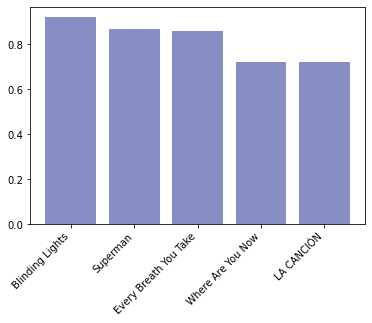

In [37]:
plt.bar(bar_df['Track Name'],bar_df['Similarity Score'], color='#868ec4')
plt.xticks(rotation=45, ha='right')
plt.savefig('resources/bar.png',dpi=600)
plt.show()